This Notebook contains an ECG classification approach using Convolutional Neural Network.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Loading

In [2]:
!unzip /content/drive/MyDrive/AppliedAIinBiomedicine/final-assignment/training_set_splitted.zip

Archive:  /content/drive/MyDrive/AppliedAIinBiomedicine/final-assignment/training_set_splitted.zip
   creating: training_set_splitted/
   creating: training_set_splitted/test/
  inflating: training_set_splitted/test/S104_250.mat  
  inflating: training_set_splitted/test/S104_250_ann.mat  
  inflating: training_set_splitted/test/S104_250_rpk.mat  
  inflating: training_set_splitted/test/S105_250.mat  
  inflating: training_set_splitted/test/S105_250_ann.mat  
 extracting: training_set_splitted/test/S105_250_rpk.mat  
  inflating: training_set_splitted/test/S106_250.mat  
  inflating: training_set_splitted/test/S106_250_ann.mat  
 extracting: training_set_splitted/test/S106_250_rpk.mat  
  inflating: training_set_splitted/test/S107_250.mat  
  inflating: training_set_splitted/test/S107_250_ann.mat  
  inflating: training_set_splitted/test/S107_250_rpk.mat  
  inflating: training_set_splitted/test/S108_250.mat  
  inflating: training_set_splitted/test/S108_250_ann.mat  
  inflating: train

In [3]:
input_dir = "/content/training_set_splitted/train"

In [4]:
import os

# list the data present in the dataset
dirs = sorted(os.listdir(input_dir))
print(dirs)

['S001_128.mat', 'S001_128_ann.mat', 'S001_128_rpk.mat', 'S002_128.mat', 'S002_128_ann.mat', 'S002_128_rpk.mat', 'S003_128.mat', 'S003_128_ann.mat', 'S003_128_rpk.mat', 'S004_128.mat', 'S004_128_ann.mat', 'S004_128_rpk.mat', 'S005_128.mat', 'S005_128_ann.mat', 'S005_128_rpk.mat', 'S006_128.mat', 'S006_128_ann.mat', 'S006_128_rpk.mat', 'S007_128.mat', 'S007_128_ann.mat', 'S007_128_rpk.mat', 'S008_128.mat', 'S008_128_ann.mat', 'S008_128_rpk.mat', 'S009_128.mat', 'S009_128_ann.mat', 'S009_128_rpk.mat', 'S010_128.mat', 'S010_128_ann.mat', 'S010_128_rpk.mat', 'S011_128.mat', 'S011_128_ann.mat', 'S011_128_rpk.mat', 'S012_128.mat', 'S012_128_ann.mat', 'S012_128_rpk.mat', 'S013_128.mat', 'S013_128_ann.mat', 'S013_128_rpk.mat', 'S014_128.mat', 'S014_128_ann.mat', 'S014_128_rpk.mat', 'S015_128.mat', 'S015_128_ann.mat', 'S015_128_rpk.mat', 'S016_128.mat', 'S016_128_ann.mat', 'S016_128_rpk.mat', 'S017_128.mat', 'S017_128_ann.mat', 'S017_128_rpk.mat', 'S018_128.mat', 'S018_128_ann.mat', 'S018_128_r

In [5]:
# environment setup
from scipy.io import loadmat
import numpy as np, os, sys, joblib
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import pandas as pd
import random

#Setting random seed for reproducibility
#Remember to use always SEED for the functions that requires it (like Scikit models)
SEED = 1234
np.random.seed(SEED)
pd.core.common._random_stat = SEED
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

In [6]:
# Utility function to load data

def load_data(ecg_file):
  ecg = loadmat(ecg_file)
  rpk_file = ecg_file.replace('.mat', '_rpk.mat')
  rpk = loadmat(rpk_file)
  ann_file = ecg_file.replace('.mat', '_ann.mat')
  ann = loadmat(ann_file)
  return ecg, rpk, ann

In [7]:
# Get the ecg file for each sample and create a list of all ecgs
ecg_files = []

for f in dirs:
  g = input_dir+'/'+f
  if g.find('_ann') == -1 and g.find('_rpk') == -1:
   ecg_files.append(g)

num_files = len(ecg_files)
# Create lists that will contains each data types (ecg, labels, rpeaks) an filenames (a list which contains the original filename for each sample)
filenames = list()
ecgs = list()
rpks = list()
anns = list()

for i in range(num_files):
  ecg, rpk, ann = load_data(ecg_files[i])
  print(
        "\rLoading file: {}/{}"
            .format(i+1, num_files),
        end=""
    )
  ecgs.append(ecg)
  rpks.append(rpk)
  anns.append(ann)
  filenames.append(ecg_files[i])

#ecg = np.asarray(loadmat(g)['ecg'], dtype=np.float64)
#rpk = np.asarray(loadmat(input_dir + "/S083_250_rpk.mat")['rpeaks'], dtype=np.float64)
#ann = np.asarray(loadmat(input_dir + "/S083_250_ann.mat")['labels'])

Loading file: 90/90

### Single beats extraction

In [8]:
! pip install neurokit2 tdqm

     |████████████████████████████████| 1.1 MB 13.5 MB/s 
  Created wheel for tdqm: filename=tdqm-0.0.1-py3-none-any.whl size=1323 sha256=24b67680f819754cec54467ff2a8709607da67c15f605097335faecb2c3577c4
  Stored in directory: /root/.cache/pip/wheels/c6/f0/d9/9fa5ff78c0f9d5a0a427bbbb4893c283520ddfccb885ea2205
Successfully built tdqm


In [9]:
import neurokit2 as nk

In [10]:
# Utility: given the filename of a signal it returns the sampling frequency
def ecg_freq(filename):
  if '128' in filename:
    return 128
  else:
    return 250

In [115]:
# Try to extract each single heartbeat 
 
# list of list that contains all heartbeats divided by patient 
patient_heartbeats = [] 
 
for i in tqdm(range(len(ecgs))): 
  # extract a sample ecgd 
  ecg_sample = np.asarray(ecgs[i]['ecg'], dtype=np.float64) 
  sampling = ecg_freq(filenames[i]) 
  #ecg_sample_= np.arange(0, ecg_sample.shape[0]/sampling, 1/sampling) 
  # clean ecg_sample 
  ecg_signal_l1 = nk.ecg_clean(ecg_sample[:,0], sampling_rate=sampling, method='neurokit2') 
  ecg_signal_l2 = nk.ecg_clean(ecg_sample[:,1], sampling_rate=sampling, method='neurokit2') 
   
  #Extract peaks from traning set and their labels 
  sample_rpeaks = rpks[i]['rpeaks']  
  # Handling last beats (if last rpeak is >= to current ecg lenght, we remove it) 
  add_padding_l1=False 
  add_padding_l2=False 
  if sample_rpeaks[-1] >= len(ecg_signal_l1): 
    #sample_labels = sample_labels[:-1] 
    sample_rpeaks = sample_rpeaks[:-1]  
    add_padding_l1 = True 
     
  if sample_rpeaks[-1] >= len(ecg_signal_l2): 
    #sample_labels = sample_labels[:-1] 
    sample_rpeaks = sample_rpeaks[:-1]  
    add_padding_l2 = True   
 
  rpeaks = {'ECG_R_Peaks': sample_rpeaks.flatten(), 'sampling_rate': sampling} 
 
  # extract heartbeats of current ecg 
  ecg_heartbeats_l1 = nk.ecg_segment(ecg_cleaned=ecg_signal_l1, rpeaks=rpeaks['ECG_R_Peaks'], sampling_rate=sampling) 
  ecg_heartbeats_l2 = nk.ecg_segment(ecg_cleaned=ecg_signal_l2, rpeaks=rpeaks['ECG_R_Peaks'], sampling_rate=sampling) 
 
  if(add_padding_l1 == True): #If we cannot extract the last beat, we replicate the last good beat 
   ecg_heartbeats_l1[str(int(list(ecg_heartbeats_l1.keys())[-1]) + 1)] = ecg_heartbeats_l1[list(ecg_heartbeats_l1.keys())[-1]] 
  if(add_padding_l2 == True): #If we cannot extract the last beat, we replicate the last good beat 
   ecg_heartbeats_l2[str(int(list(ecg_heartbeats_l2.keys())[-1]) + 1)] = ecg_heartbeats_l2[list(ecg_heartbeats_l2.keys())[-1]]  
 
  patient_heartbeats.append([ecg_heartbeats_l1, ecg_heartbeats_l2])

100%|██████████| 90/90 [17:26<00:00, 11.63s/it]


In [12]:
#load the heartbeats inside an array
heartbeats = []

for p in range(len(patient_heartbeats)):
  if(len(patient_heartbeats[p][0]) >= len(patient_heartbeats[p][1])):
   keys = patient_heartbeats[p][0].keys()
  else:
   keys = patient_heartbeats[p][1].keys()
  for b in keys:
   try:
    lead1 = list(patient_heartbeats[p][0][b].Signal)
   except:
    lead1 = list()
   try:  
    lead2 = list(patient_heartbeats[p][1][b].Signal)
   except:
    lead2 = list()
    
   heartbeats.append([lead1, lead2])

In [13]:
#removing nan values and substituting them with 0s
for i in range(len(heartbeats)):
    for j in [0, 1]:
      for k in range(len(heartbeats[i][j])):
        if(str(heartbeats[i][j][k]) == 'nan'):
            heartbeats[i][j][k] = 0

In [126]:
# free some RAM usages
patient_heartbeats = []

In [15]:
classes_name = ['N', 'S', 'V']

In [16]:
# list which contains all labels of each beat
all_labels = []

for sample in anns:
  for beat in sample['labels']:
    all_labels.append(beat)

In [17]:
print(len(all_labels))
print(len(heartbeats))

213024
213024


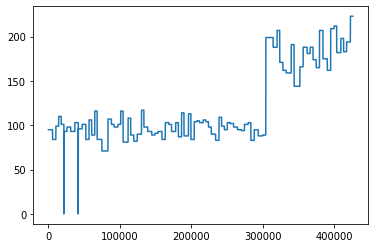

In [18]:
lengths = []
for b in heartbeats:
  for a in [0, 1]:
   lengths.append(len(b[a]))

import matplotlib.pyplot as plt

plt.plot(lengths)

max_len = max(lengths)

In [19]:
# hand-crafted padding of all beats
for beat in heartbeats:
  while len(beat[0]) != max_len:
    beat[0].append(0)

for beat in heartbeats:
  while len(beat[1]) != max_len:
    beat[1].append(0)

In [ ]:
#features = dict(patient_heartbeats = heartbeats, target = all_labels)

In [ ]:
#features_df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in features.items() ]))

### Preprocessing

Here we perform some data preprocessing to prepare them for the NN model. In particular:

*   We encode labels with one hot encoding
*   We split data in training and validation set
*   We compute class weights to deal with class imbalance problem
*   We normalize the data
*   Finally we create a batch generator to not load all data in RAM during training







In [20]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(all_labels)

#One hot encoding of the target values
ohe = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
target_ohe = ohe.fit_transform(integer_encoded)

In [21]:
label_encoder.inverse_transform([0,1,2])

array(['N', 'S', 'V'], dtype='<U1')

In [22]:
ohe.inverse_transform([[1, 0, 0], [0,1,0], [0,0,1]])

array([[0],
       [1],
       [2]])

In [199]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(heartbeats, target_ohe, test_size=0.2, random_state=SEED,
                               shuffle=True, stratify=target_ohe)

In [ ]:
#!pip install imbalanced-learn

In [ ]:
# RESAMPLING TO DEAL THE HEAVY CLASS IMBALANCE (it does not work for now)

# Perform resampling over the dataset to balance classes
# example of random undersampling to balance the class distribution
#from collections import Counter
#from sklearn.datasets import make_classification
#from imblearn.under_sampling import RandomUnderSampler

#y_integers = np.argmax(y_train, axis=1)
# summarize class distribution
#print(Counter(np.ravel(y_integers)))
# define undersample strategy
#undersample = RandomUnderSampler(sampling_strategy='majority')
# fit and apply the transform (applied 2 times to balance all classes)
#X_train, y_train = undersample.fit_resample(X_train, y_train)
##X_train, y_train = undersample.fit_resample(X_train, y_train)
#train_features, train_target = undersample.fit_resample(train_features, train_target)
# summarize class distribution
#y_integers = np.argmax(y_train, axis=1)
#print(Counter(np.ravel(y_integers)))

Counter({0: 156815, 1: 7454, 2: 6150})
Counter({0: 6150, 1: 6150, 2: 6150})


In [200]:
 X_train = np.array(X_train)
X_val = np.array(X_val)
type(X_train)

numpy.ndarray

In [201]:
X_train.shape

(170419, 2, 223)

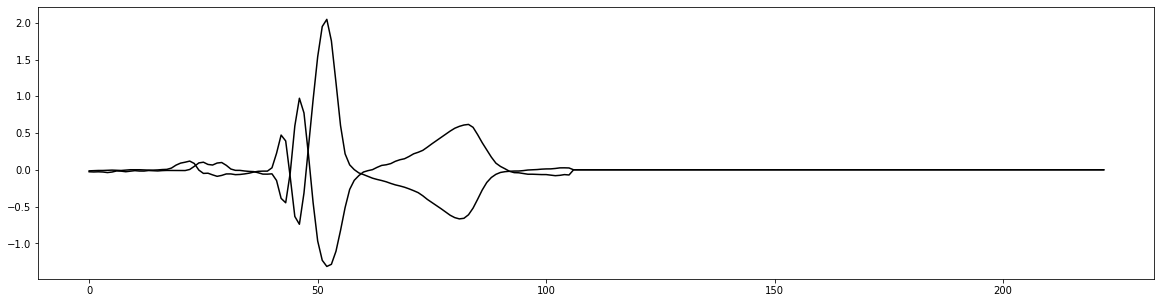

In [202]:
# plot two leads of a single beat
plt.figure(figsize=(20, 5))
plt.plot(X_train[2][0], 'k')
plt.plot(X_train[2][1], 'k')
plt.show()

In [203]:
X_train = np.swapaxes(X_train, 1, 2)

X_val = np.swapaxes(X_val, 1, 2)
#X_train = X_train.reshape(-1, max_len, 2)

#X_val = X_val.reshape(-1, max_len, 2)


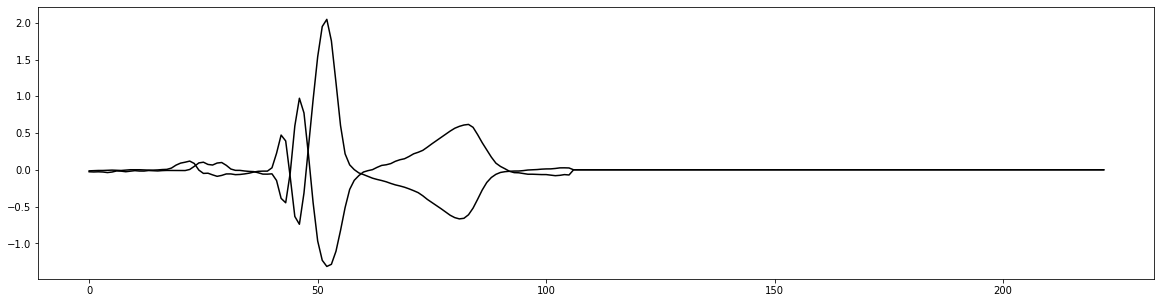

In [204]:
# check consistency after reshaping
plt.figure(figsize=(20, 5))
plt.plot(X_train[2], 'k')
#plt.plot(X_train[0], 'k')
plt.show()

In [205]:
X_train.shape

(170419, 223, 2)

In [206]:
len(y_train)

170419

In [207]:
# Considering class imbalance: class weightning to reduce the bias in the dataset

from sklearn.utils.class_weight import compute_class_weight

y_integers = np.argmax(y_train, axis=1)

class_weights = compute_class_weight(
                                      class_weight = "balanced",
                                      classes = np.unique(y_integers),
                                      y = y_integers                                             
                                    )

class_weights = dict(zip(np.unique(y_integers), class_weights))
class_weights

{0: 0.3622506350370394, 1: 7.620919416867901, 2: 9.236802168021681}

In [208]:
X_train.shape, y_train.shape

((170419, 223, 2), (170419, 3))

In [174]:
# Normalize data (used for resnet, not for vgg)
mean = np.mean(X_train, axis=1).mean(axis=0)
std = np.std(X_train, axis=1).mean(axis=0)

X_train = (X_train - mean)/std
X_val = (X_val - mean)/std

In [209]:
# Here we load validation data, training data can be loaded with the batch generator below
import tensorflow as tf

train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
validation_data = tf.data.Dataset.from_tensor_slices((X_val, y_val))

In [ ]:
# We will use this method in the fit() function to load one batch at time
def batch_generator_data(batch_size, x_gen, y_gen): 
    
    batch_features = np.zeros((batch_size, max_len, 2))
    batch_labels = np.zeros((batch_size,3)) 
    
    while True:
        for i in range(batch_size):

            batch_features[i] = next(x_gen)
            batch_labels[i] = next(y_gen)
            
        X = [batch_features]

        yield X, batch_labels

def generate_y_shuffle(y):
    while True:
        for i in y:
            y_generated = i
            yield y_generated


def generate_X_shuffle(x):
    while True:
        for i in x:
          x_generated = i
          yield x_generated

def compute_steps(len, batch_size):
  if len%batch_size != 0:
    return len/batch_size + 1
  return len/batch_size


# Simple CNN model

Now Let's define the model, a simple CNN with 1D convolution layers

In [ ]:
cnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=16, kernel_size=3, padding='same',
                        activation=tf.nn.leaky_relu, input_shape=[max_len, 1]),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                        padding='same', activation=tf.nn.leaky_relu),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(128, activation=tf.nn.leaky_relu),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(3, activation=tf.nn.softmax)
])

In [ ]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_40 (Conv1D)          (None, 223, 16)           64        
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 111, 16)          0         
 1D)                                                             
                                                                 
 conv1d_41 (Conv1D)          (None, 111, 64)           3136      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                        

In [ ]:
learning_rate = 0.001
cnn_model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy', tf.keras.metrics.Precision(),tf.keras.metrics.Recall()]
)

In [ ]:
batch_size = 16

history = cnn_model.fit(
    x = batch_generator_data(batch_size = batch_size, x_gen = generate_X_shuffle(X_train), y_gen = generate_y_shuffle(y_train)), 
    validation_data=validation_data.batch(batch_size),
    steps_per_epoch=compute_steps(len(X_train), batch_size),
    epochs = 15,
    callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True),
    class_weight = class_weights
).history

Epoch 1/15
10652/10652 [==============================] - 100s 9ms/step - loss: 0.6393 - accuracy: 0.6851 - precision_13: 0.7167 - recall_13: 0.6054 - val_loss: 0.6193 - val_accuracy: 0.7207 - val_precision_13: 0.7443 - val_recall_13: 0.6741
Epoch 2/15
10652/10652 [==============================] - 110s 10ms/step - loss: 0.4961 - accuracy: 0.7758 - precision_13: 0.7910 - recall_13: 0.7531 - val_loss: 0.4922 - val_accuracy: 0.7892 - val_precision_13: 0.8056 - val_recall_13: 0.7644
Epoch 3/15
10652/10652 [==============================] - 109s 10ms/step - loss: 0.4536 - accuracy: 0.7973 - precision_13: 0.8099 - recall_13: 0.7803 - val_loss: 0.4255 - val_accuracy: 0.8265 - val_precision_13: 0.8403 - val_recall_13: 0.8063
Epoch 4/15
10652/10652 [==============================] - 124s 12ms/step - loss: 0.4312 - accuracy: 0.8058 - precision_13: 0.8172 - recall_13: 0.7900 - val_loss: 0.3929 - val_accuracy: 0.8406 - val_precision_13: 0.8535 - val_recall_13: 0.8231
Epoch 5/15
10652/10652 [=====

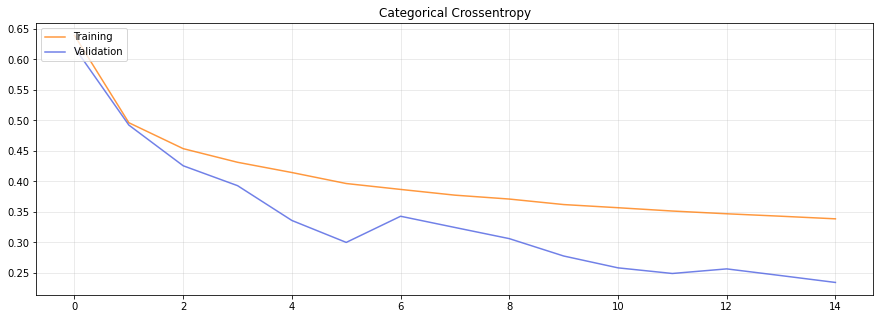

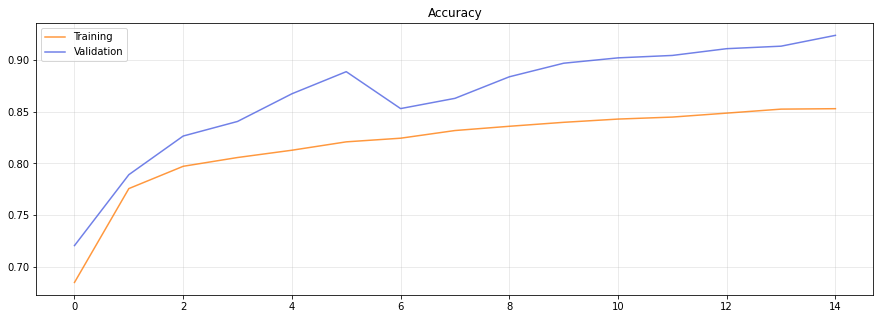

In [ ]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
#Computing the prediction of the model on the validation set
predictions = []
for element in validation_data.batch(128).as_numpy_iterator():
    predictions.append(cnn_model.predict(element[0]))

In [ ]:
predictions_f = [item for sublist in predictions for item in sublist]

In [ ]:
predictions_oh = []
#transform prediction into one-hot-encoding 
for i in range(len(predictions_f)):
    predictions_oh.append(tf.one_hot(tf.argmax(predictions_f[i]), depth=3))

In [ ]:
#Compute the true and prediction array in order to plot the confusion matrix
y = []

for y_t in y_val.tolist():
    if(y_t == [1, 0, 0]):
        y.append('N')
    if(y_t == [0, 1 ,0]):
        y.append('S')
    if(y_t == [0, 0 ,1]):
        y.append('V')    

y_pred = []

for y_t in predictions_oh:
    if(all(tf.equal(y_t, tf.constant([1, 0, 0], dtype=np.float32)))):
        y_pred.append('N')
    elif(all(tf.equal(y_t, tf.constant([0, 1, 0], dtype=np.float32)))):
        y_pred.append('S')
    elif(all(tf.equal(y_t, tf.constant([0, 0, 1], dtype=np.float32)))):
        y_pred.append('V')  
    else:
        print(y_t)    

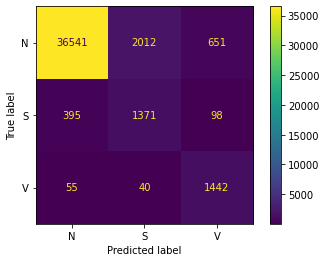

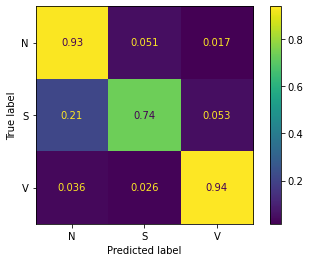

In [ ]:
#Plotting the confusion matrix
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.metrics import confusion_matrix

ConfusionMatrixDisplay.from_predictions(y, y_pred, labels = ['N', 'S', 'V'])
ConfusionMatrixDisplay.from_predictions(y, y_pred, normalize='true', labels = ['N', 'S', 'V'])

In [ ]:
print(classification_report(y,y_pred))

              precision    recall  f1-score   support

           N       0.99      0.93      0.96     39204
           S       0.40      0.74      0.52      1864
           V       0.66      0.94      0.77      1537

    accuracy                           0.92     42605
   macro avg       0.68      0.87      0.75     42605
weighted avg       0.95      0.92      0.93     42605



# VGG 1D

In [210]:
vgg = tf.keras.Sequential()

vgg.add(tf.keras.layers.Conv1D(input_shape=[max_len, 2],filters=64,kernel_size=3,padding="same", activation="relu"))
vgg.add(tf.keras.layers.Conv1D(filters=64,kernel_size=3,padding="same", activation="relu"))
vgg.add(tf.keras.layers.MaxPooling1D(pool_size=2,strides=2))
vgg.add(tf.keras.layers.Conv1D(filters=128, kernel_size=3, padding="same", activation="relu"))
vgg.add(tf.keras.layers.Conv1D(filters=128, kernel_size=3, padding="same", activation="relu"))
vgg.add(tf.keras.layers.MaxPooling1D(pool_size=2,strides=2))
vgg.add(tf.keras.layers.Conv1D(filters=256, kernel_size=3, padding="same", activation="relu"))
vgg.add(tf.keras.layers.Conv1D(filters=256, kernel_size=3, padding="same", activation="relu"))
vgg.add(tf.keras.layers.Conv1D(filters=256, kernel_size=3, padding="same", activation="relu"))
vgg.add(tf.keras.layers.MaxPooling1D(pool_size=2,strides=2))
vgg.add(tf.keras.layers.Conv1D(filters=512, kernel_size=3, padding="same", activation="relu"))
vgg.add(tf.keras.layers.Conv1D(filters=512, kernel_size=3, padding="same", activation="relu"))
vgg.add(tf.keras.layers.Conv1D(filters=512, kernel_size=3, padding="same", activation="relu"))
vgg.add(tf.keras.layers.MaxPooling1D(pool_size=2,strides=2))
vgg.add(tf.keras.layers.Conv1D(filters=512, kernel_size=3, padding="same", activation="relu"))
vgg.add(tf.keras.layers.Conv1D(filters=512, kernel_size=3, padding="same", activation="relu"))
vgg.add(tf.keras.layers.Conv1D(filters=512, kernel_size=3, padding="same", activation="relu"))
vgg.add(tf.keras.layers.MaxPooling1D(pool_size=2,strides=2))
vgg.add(tf.keras.layers.GlobalMaxPooling1D())
vgg.add(tf.keras.layers.Dense(512, activation='relu'))
vgg.add(tf.keras.layers.Dropout(0.4))
vgg.add(tf.keras.layers.Dense(3,activation='softmax'))


learning_rate = 0.001
vgg.compile(
    optimizer = tf.keras.optimizers.Adam(1e-4),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy', tf.keras.metrics.Precision(),tf.keras.metrics.Recall()]
)

In [211]:
vgg.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_17 (Conv1D)          (None, 223, 64)           448       
                                                                 
 conv1d_18 (Conv1D)          (None, 223, 64)           12352     
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 111, 64)          0         
 1D)                                                             
                                                                 
 conv1d_19 (Conv1D)          (None, 111, 128)          24704     
                                                                 
 conv1d_20 (Conv1D)          (None, 111, 128)          49280     
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 55, 128)          0         
 1D)                                                  

In [212]:
class_weights

{0: 0.3622506350370394, 1: 7.620919416867901, 2: 9.236802168021681}

In [213]:
history = vgg.fit(train_data.batch(128), 
    validation_data=validation_data.batch(128),
    shuffle= True,
    epochs = 15,
    callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True),
    class_weight = class_weights
).history

Epoch 1/15
   3/1332 [..............................] - ETA: 57:39 - loss: 1.1186 - accuracy: 0.1536 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00

KeyboardInterrupt: ignored

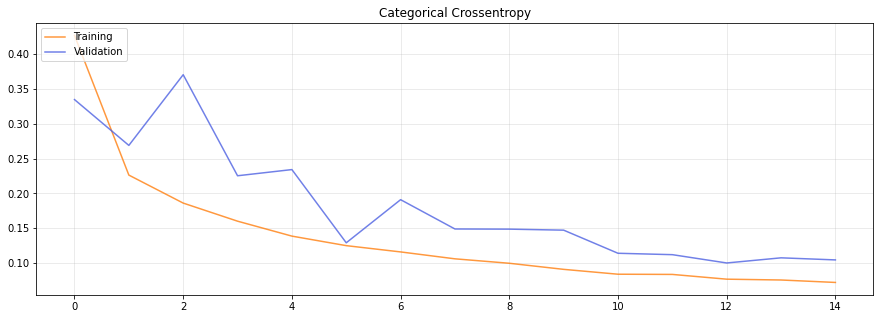

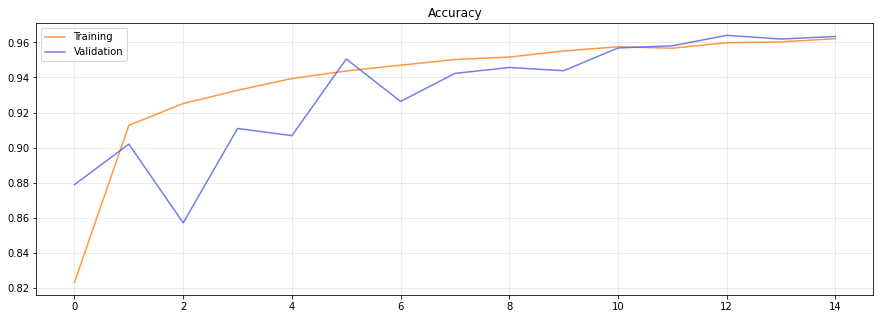

In [ ]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
#Computing the prediction of the model on the validation set
predictions = []
for element in validation_data.batch(128).as_numpy_iterator():
    predictions.append(vgg.predict(element[0]))

In [ ]:
predictions_f = [item for sublist in predictions for item in sublist]

In [ ]:
predictions_oh = []
#transform prediction into one-hot-encoding 
for i in range(len(predictions_f)):
    predictions_oh.append(tf.one_hot(tf.argmax(predictions_f[i]), depth=3))

In [ ]:
#Compute the true and prediction array in order to plot the confusion matrix
y = []

for y_t in y_val.tolist():
    if(y_t == [1, 0, 0]):
        y.append('N')
    if(y_t == [0, 1 ,0]):
        y.append('S')
    if(y_t == [0, 0 ,1]):
        y.append('V')    

y_pred = []

for y_t in predictions_oh:
    if(all(tf.equal(y_t, tf.constant([1, 0, 0], dtype=np.float32)))):
        y_pred.append('N')
    elif(all(tf.equal(y_t, tf.constant([0, 1, 0], dtype=np.float32)))):
        y_pred.append('S')
    elif(all(tf.equal(y_t, tf.constant([0, 0, 1], dtype=np.float32)))):
        y_pred.append('V')  
    else:
        print(y_t)  

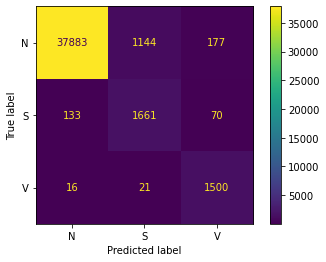

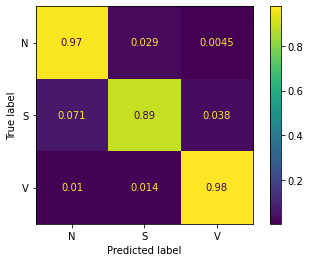

In [ ]:
#Plotting the confusion matrix
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.metrics import confusion_matrix

ConfusionMatrixDisplay.from_predictions(y, y_pred, labels = ['N', 'S', 'V'])
ConfusionMatrixDisplay.from_predictions(y, y_pred, normalize='true', labels = ['N', 'S', 'V'])

In [ ]:
print(classification_report(y,y_pred))

              precision    recall  f1-score   support

           N       1.00      0.97      0.98     39204
           S       0.59      0.89      0.71      1864
           V       0.86      0.98      0.91      1537

    accuracy                           0.96     42605
   macro avg       0.81      0.94      0.87     42605
weighted avg       0.97      0.96      0.97     42605



In [ ]:
vgg.save('/content/drive/MyDrive/AppliedAIinBiomedicine/final-assignment/vgg model 2 leads normalized')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/AppliedAIinBiomedicine/final-assignment/vgg model 2 leads normalized/assets


## VGG-1D with Attention Mechanism

Idea adapted from the paper *ECG-Based Heart Arrhythmia Diagnosis Through
Attentional Convolutional Neural Networks* by Liu et al.

In [ ]:
input = tf.keras.Input(shape= [max_len, 1])

#attention = tf.keras.layers.MultiHeadAttention(num_heads = 32, key_dim = int(max_len/32) )(input, input ,return_attention_scores=False)
attention = tf.keras.layers.Dense(max_len, activation='softmax')(input)

mul = tf.keras.layers.Multiply()([input, attention])

layer = tf.keras.layers.Conv1D(filters=64,kernel_size=3,padding="same", activation="relu")(mul)
layer = tf.keras.layers.Conv1D(filters=64,kernel_size=3,padding="same", activation="relu")(layer)
layer = tf.keras.layers.MaxPooling1D(pool_size=2,strides=2)(layer)
layer = tf.keras.layers.Conv1D(filters=128, kernel_size=3, padding="same", activation="relu")(layer)
layer = tf.keras.layers.Conv1D(filters=128, kernel_size=3, padding="same", activation="relu")(layer)
layer = tf.keras.layers.MaxPooling1D(pool_size=2,strides=2)(layer)
layer = tf.keras.layers.Conv1D(filters=256, kernel_size=3, padding="same", activation="relu")(layer)
layer = tf.keras.layers.Conv1D(filters=256, kernel_size=3, padding="same", activation="relu")(layer)
layer = tf.keras.layers.Conv1D(filters=256, kernel_size=3, padding="same", activation="relu")(layer)
layer = tf.keras.layers.MaxPooling1D(pool_size=2,strides=2)(layer)
layer = tf.keras.layers.Conv1D(filters=512, kernel_size=3, padding="same", activation="relu")(layer)
layer = tf.keras.layers.Conv1D(filters=512, kernel_size=3, padding="same", activation="relu")(layer)
layer = tf.keras.layers.Conv1D(filters=512, kernel_size=3, padding="same", activation="relu")(layer)
layer = tf.keras.layers.MaxPooling1D(pool_size=2,strides=2)(layer)
layer = tf.keras.layers.Conv1D(filters=512, kernel_size=3, padding="same", activation="relu")(layer)
layer = tf.keras.layers.Conv1D(filters=512, kernel_size=3, padding="same", activation="relu")(layer)
layer = tf.keras.layers.Conv1D(filters=512, kernel_size=3, padding="same", activation="relu")(layer)
layer = tf.keras.layers.MaxPooling1D(pool_size=2,strides=2)(layer)
layer = tf.keras.layers.GlobalMaxPooling1D()(layer)
layer = tf.keras.layers.Dense(512, activation='relu')(layer)
layer = tf.keras.layers.Dropout(0.4)(layer)
output = tf.keras.layers.Dense(3,activation='softmax')(layer)

model = tf.keras.Model(inputs = input , outputs = output)

learning_rate = 0.001
model.compile(
    optimizer = tf.keras.optimizers.Adam(1e-4),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy', tf.keras.metrics.Precision(),tf.keras.metrics.Recall()]
)

In [ ]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 223, 1)]     0           []                               
                                                                                                  
 dense_9 (Dense)                (None, 223, 223)     446         ['input_4[0][0]']                
                                                                                                  
 multiply_1 (Multiply)          (None, 223, 223)     0           ['input_4[0][0]',                
                                                                  'dense_9[0][0]']                
                                                                                                  
 conv1d_17 (Conv1D)             (None, 223, 64)      42880       ['multiply_1[0][0]']       

In [ ]:
history = model.fit(train_data.batch(128), 
    validation_data=validation_data.batch(128),
    shuffle= True,
    epochs = 15,
    callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True),
    class_weight = class_weights
).history

Epoch 1/15
1332/1332 [==============================] - 225s 165ms/step - loss: 0.6682 - accuracy: 0.6758 - precision_3: 0.7409 - recall_3: 0.5416 - val_loss: 0.3469 - val_accuracy: 0.8994 - val_precision_3: 0.9100 - val_recall_3: 0.8843
Epoch 2/15
1332/1332 [==============================] - 216s 162ms/step - loss: 0.3578 - accuracy: 0.8657 - precision_3: 0.8764 - recall_3: 0.8527 - val_loss: 0.3143 - val_accuracy: 0.8848 - val_precision_3: 0.8926 - val_recall_3: 0.8746
Epoch 3/15
1332/1332 [==============================] - 216s 162ms/step - loss: 0.2676 - accuracy: 0.8987 - precision_3: 0.9051 - recall_3: 0.8920 - val_loss: 0.3362 - val_accuracy: 0.8679 - val_precision_3: 0.8757 - val_recall_3: 0.8615
Epoch 4/15
1332/1332 [==============================] - 216s 162ms/step - loss: 0.2247 - accuracy: 0.9120 - precision_3: 0.9174 - recall_3: 0.9073 - val_loss: 0.2546 - val_accuracy: 0.8970 - val_precision_3: 0.9058 - val_recall_3: 0.8918
Epoch 5/15
1332/1332 [==========================

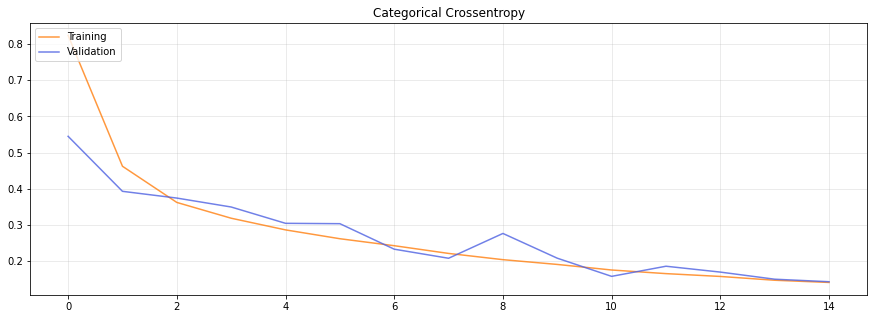

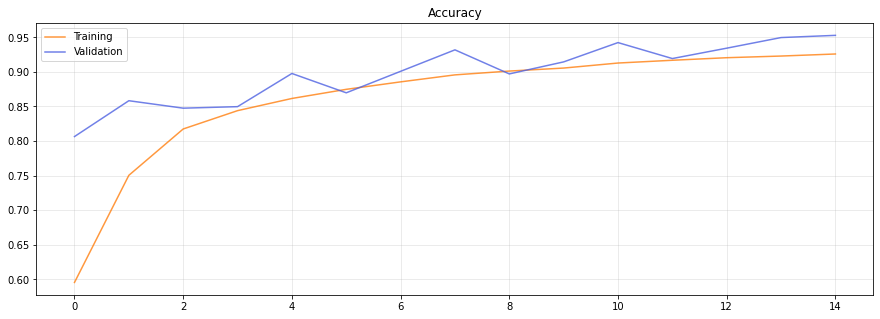

In [ ]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
#Computing the prediction of the model on the validation set
predictions = []
for element in validation_data.batch(128).as_numpy_iterator():
    predictions.append(model.predict(element[0]))

In [ ]:
predictions_f = [item for sublist in predictions for item in sublist]

In [ ]:
predictions_oh = []
#transform prediction into one-hot-encoding 
for i in range(len(predictions_f)):
    predictions_oh.append(tf.one_hot(tf.argmax(predictions_f[i]), depth=3))

In [ ]:
#Compute the true and prediction array in order to plot the confusion matrix
y = []

for y_t in y_val.tolist():
    if(y_t == [1, 0, 0]):
        y.append('N')
    if(y_t == [0, 1 ,0]):
        y.append('S')
    if(y_t == [0, 0 ,1]):
        y.append('V')    

y_pred = []

for y_t in predictions_oh:
    if(all(tf.equal(y_t, tf.constant([1, 0, 0], dtype=np.float32)))):
        y_pred.append('N')
    elif(all(tf.equal(y_t, tf.constant([0, 1, 0], dtype=np.float32)))):
        y_pred.append('S')
    elif(all(tf.equal(y_t, tf.constant([0, 0, 1], dtype=np.float32)))):
        y_pred.append('V')  
    else:
        print(y_t)  

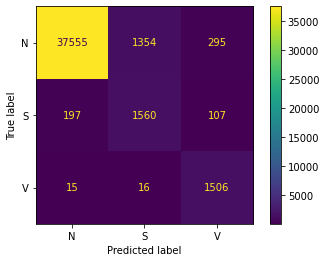

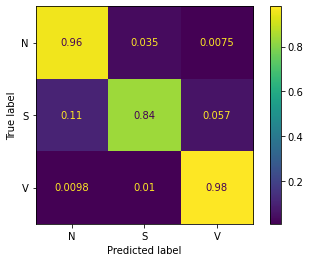

In [ ]:
#Plotting the confusion matrix
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.metrics import confusion_matrix

ConfusionMatrixDisplay.from_predictions(y, y_pred, labels = ['N', 'S', 'V'])
ConfusionMatrixDisplay.from_predictions(y, y_pred, normalize='true', labels = ['N', 'S', 'V'])

In [ ]:
print(classification_report(y,y_pred))

              precision    recall  f1-score   support

           N       0.99      0.96      0.98     39204
           S       0.53      0.84      0.65      1864
           V       0.79      0.98      0.87      1537

    accuracy                           0.95     42605
   macro avg       0.77      0.92      0.83     42605
weighted avg       0.97      0.95      0.96     42605



In [ ]:
input = tf.keras.Input(shape= [max_len, 1])

#attention = tf.keras.layers.MultiHeadAttention(num_heads = 32, key_dim = int(max_len/32) )(input, input ,return_attention_scores=False)

#mul = tf.keras.layers.Multiply()([input, attention])

layer = tf.keras.layers.Conv1D(filters=2,kernel_size=1,padding="same")(attention)
layer = tf.keras.layers.MaxPooling1D(pool_size=2,strides=1)(layer)
layer = tf.keras.layers.ReLU()(layer)
layer = tf.keras.layers.Conv1D(filters=4, kernel_size=1, padding="same")(layer)
layer = tf.keras.layers.MaxPooling1D(pool_size=2,strides=1)(layer)
layer = tf.keras.layers.ReLU()(layer)
layer = tf.keras.layers.Flatten()(layer)
layer = tf.keras.layers.Dense(240, activation='relu')(layer)
layer = tf.keras.layers.Dropout(0.3)(layer)
layer = tf.keras.layers.Dense(60, activation='relu')(layer)
layer = tf.keras.layers.Dropout(0.3)(layer)
output = tf.keras.layers.Dense(3,activation='softmax')(layer)

model = tf.keras.Model(inputs = input , outputs = output)

learning_rate = 0.001
model.compile(
    optimizer = tf.keras.optimizers.Adam(1e-4),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy', tf.keras.metrics.Precision(),tf.keras.metrics.Recall()]
)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 223, 1)]     0           []                               
                                                                                                  
 multi_head_attention_1 (MultiH  (None, 223, 1)      1345        ['input_2[0][0]',                
 eadAttention)                                                    'input_2[0][0]']                
                                                                                                  
 conv1d_2 (Conv1D)              (None, 223, 2)       4           ['multi_head_attention_1[0][0]'] 
                                                                                                  
 max_pooling1d_2 (MaxPooling1D)  (None, 222, 2)      0           ['conv1d_2[0][0]']         

In [ ]:
history = model.fit(train_data.batch(128), 
    validation_data=validation_data.batch(128),
    shuffle= True,
    epochs = 15,
    callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True),
    class_weight = class_weights
).history

Epoch 1/15
1332/1332 [==============================] - 376s 279ms/step - loss: 1.0064 - accuracy: 0.6092 - precision_1: 0.2217 - recall_1: 0.0117 - val_loss: 0.9933 - val_accuracy: 0.7485 - val_precision_1: 0.2466 - val_recall_1: 0.0188
Epoch 2/15
1332/1332 [==============================] - 369s 277ms/step - loss: 0.9165 - accuracy: 0.6020 - precision_1: 0.3575 - recall_1: 0.0311 - val_loss: 0.9575 - val_accuracy: 0.6676 - val_precision_1: 0.4200 - val_recall_1: 0.0438
Epoch 3/15
1332/1332 [==============================] - 370s 278ms/step - loss: 0.8725 - accuracy: 0.5851 - precision_1: 0.6388 - recall_1: 0.1121 - val_loss: 0.9133 - val_accuracy: 0.7051 - val_precision_1: 0.6103 - val_recall_1: 0.1139
Epoch 4/15
1332/1332 [==============================] - 370s 278ms/step - loss: 0.8223 - accuracy: 0.5980 - precision_1: 0.7082 - recall_1: 0.2116 - val_loss: 0.8498 - val_accuracy: 0.7187 - val_precision_1: 0.6812 - val_recall_1: 0.1854
Epoch 5/15
 780/1332 [================>.........

KeyboardInterrupt: ignored

# Explainability through CAM (Class Activation Map) and LIME

In this section we want to make results of our deep model more interpretable using Class Activation Map, which give us an indication about which part of the input influence more its final classification. We try to use Grad-CAM, an extension of simple CAM that can be used with all kinds of CNN models

Use our previous vgg model to create CAM

In [ ]:
# Load our pre-trained model
#model = tf.keras.models.load_model('/content/drive/MyDrive/AppliedAIinBiomedicine/final-assignment/vgg model')
#model = tf.keras.models.load_model('/content/drive/MyDrive/AppliedAIinBiomedicine/final-assignment/resnet model')
model = tf.keras.models.load_model('/content/drive/MyDrive/AppliedAIinBiomedicine/final-assignment/vgg model 2 leads normalized')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_26 (Conv1D)          (None, 223, 64)           448       
                                                                 
 conv1d_27 (Conv1D)          (None, 223, 64)           12352     
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 111, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_28 (Conv1D)          (None, 111, 128)          24704     
                                                                 
 conv1d_29 (Conv1D)          (None, 111, 128)          49280     
                                                                 
 max_pooling1d_11 (MaxPoolin  (None, 55, 128)          0         
 g1D)                                                 

In [ ]:
# utility function that will create the CAM of a single input
def grad_cam(layer, input):
  
  # we extract the output of the last convolutional layer, given an input to the CNN
  grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer).output, model.output])
  last_conv_output, predictions = grad_model(input)

  with tf.GradientTape() as g:
    last_conv_output, predictions = grad_model(input)
    pred_index = tf.argmax(predictions[0])
    class_channel = predictions[:, pred_index]
  
  # compute the gradient of the top predicted class wrt the activations of chosen convolutional layer
  grads = g.gradient(class_channel, last_conv_output)

  pooled_grads = tf.reduce_mean(grads, axis=(0))

  last_conv_output = last_conv_output[0]

  # We finally create the CAM heatmap multiplying the last conv layer output and the gradients computed
  heatmap = last_conv_output * pooled_grads
  heatmap = tf.reduce_mean(heatmap, axis=(1))
  heatmap = np.expand_dims(heatmap, 0)
  return heatmap

In [ ]:
# try to plot a CAM

# take into consideration the last convolutional layer of the model
layer_considered = "conv1d_38"
labels = ['N', 'S', 'V']

# beat of validation set to plot
input_index = 4
input = np.expand_dims(X_val[input_index], 0)

pred_probs = []
for i in range(3):
  pred_ci = model.predict(input)[0][i]
  pred_probs.append(pred_ci)

# obtain the predicted label of our input
label_index = pred_probs.index(max(pred_probs))
true_label_index = ohe.inverse_transform(y_val[input_index ].reshape(1, -1))[0]

#compute heatmap for our input
heatmap = grad_cam(layer_considered, input)

# plotting heatmap over the beat sample
print(f"Model prediction = {labels[label_index]} with probability = {max(pred_probs)}, True label = {labels[int(true_label_index)]}")

plt.figure(figsize=(20, 5))
plt.imshow(heatmap, cmap='Reds', aspect="auto", interpolation='nearest', extent=[0, max_len, input.min(), input.max()], alpha=0.5)
plt.plot(input.reshape(max_len, 2), 'k')
plt.colorbar()
plt.show()

InvalidArgumentError: ignored

We now try an other explainabilty technique called LIME (IT SEEMS IT DOES NOT WORK)

In [ ]:
# utility class
class model_wrapper:
  def __init__(self, model):
    self.model = model
  
  def predict(self, input_data):
    self.pred = self.model.predict(input_data).ravel()
    return np.array([self.pred]).reshape(input_data.shape[0], 3)

In [ ]:
wrapped_model = model_wrapper(model) 

In [ ]:
!pip install lime

     |████████████████████████████████| 275 kB 5.3 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=621b31e0ea5a4116e3bec28aafc122f3af6af276fa0d22971087cb627a42662d
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [ ]:
# create a lime object with our data

import lime
from lime import lime_tabular

# we use the Recurrent Tabular Explainer for our CNN model
explainer = lime_tabular.RecurrentTabularExplainer(X_train, training_labels=tf.keras.utils.to_categorical(y_train), feature_names=["beat sample"], discretize_continuous=False, feature_selection='auto', class_names=['N','S','V'])

In [ ]:
# try to plot lime heatmap

# take into consideration the last convolutional layer of the model
labels = ['N', 'S', 'V']

# beat of validation set to plot
input_index = 40209
input = np.expand_dims(X_val[input_index], axis=0)

pred_probs = []
for i in range(3):
  pred_ci = model.predict(input)[0][i]
  pred_probs.append(pred_ci)

# obtain the predicted label of our input
label_index = pred_probs.index(max(pred_probs))
true_label_index = ohe.inverse_transform(y_val[input_index ].reshape(1, -1))[0]

#compute heatmap for our input
exp = explainer.explain_instance(input, wrapped_model.predict, num_features=max_len, labels=[0, 1, 2])
explanations = exp.as_list(label=label_index)

# creating our heatmap of explanations
heatmap = np.zeros([1,max_len])
for i, k in enumerate(explanations):
  if k[1] > 0:
    heatmap[0, (max_len-1) - int(k[0].split("-")[-1])] = k[1]

# plotting heatmap over the beat sample
print(f"Model prediction = {labels[label_index]} with probability = {max(pred_probs)}, True label = {labels[int(true_label_index)]}")
plt.figure(figsize=(20, 5))
plt.imshow(heatmap, cmap='Reds', aspect="auto", interpolation='nearest', extent=[0, max_len, input.min(), input.max()], alpha=0.5)
plt.plot(input.reshape(max_len), 'k')
plt.colorbar()
plt.show()

IndexError: ignored

# Discrete Wavelet Transform experiments

Here we try to create for each heartbeat signal, its dwt representation (which results in a 2D tensor). It is shift invariant and brings lot of information on the signal which is a nice property for a classification task

In [ ]:
!pip install PyWavelets

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(heartbeats, target_ohe, test_size=0.2, random_state=SEED,
                               shuffle=True, stratify=target_ohe)

In [ ]:
# Extract the dwt representation of the heartbeats to improve the classification learning of our CNN model
import pywt
wavelet_name = 'db2'

dwt_coeffs = []
dwt_coeffs_val = []

for i in tqdm(range(len(X_train))):
  coeffs = pywt.wavedec(X_train[i], wavelet_name, level=8)
  dwt_coeffs.append(coeffs)

for i in tqdm(range(len(X_val))):
  coeffs = pywt.wavedec(X_val[i], wavelet_name, level=8)
  dwt_coeffs_val.append(coeffs)

  0%|          | 0/170419 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/pywt/_multilevel.py:45: UserWarning: Level value of 8 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))
100%|██████████| 42605/42605 [00:13<00:00, 3260.56it/s]


In [ ]:
# for each heartbeat concatenate all the level of the dwt to create a 1D input to our CNN
X_train_dwt = []
X_val_dwt = []

for coeff_list in dwt_coeffs:
  X_train_dwt.append(np.concatenate( coeff_list, axis=0 ))

for coeff_list in dwt_coeffs_val:
  X_val_dwt.append(np.vstack(np.concatenate( coeff_list, axis=0 )))

In [ ]:
#train_data_dwt = tf.data.Dataset.from_tensor_slices((X_train_dwt, y_train))
validation_data_dwt = tf.data.Dataset.from_tensor_slices((X_val_dwt, y_val))

In [ ]:
# the input shape is changed so we update the model with the new input shape

vgg = tf.keras.Sequential()

vgg.add(tf.keras.layers.Conv1D(input_shape=[242, 1],filters=64,kernel_size=3,padding="same", activation="relu"))
vgg.add(tf.keras.layers.Conv1D(filters=64,kernel_size=3,padding="same", activation="relu"))
vgg.add(tf.keras.layers.MaxPooling1D(pool_size=2,strides=2))
vgg.add(tf.keras.layers.Conv1D(filters=128, kernel_size=3, padding="same", activation="relu"))
vgg.add(tf.keras.layers.Conv1D(filters=128, kernel_size=3, padding="same", activation="relu"))
vgg.add(tf.keras.layers.MaxPooling1D(pool_size=2,strides=2))
vgg.add(tf.keras.layers.Conv1D(filters=256, kernel_size=3, padding="same", activation="relu"))
vgg.add(tf.keras.layers.Conv1D(filters=256, kernel_size=3, padding="same", activation="relu"))
vgg.add(tf.keras.layers.Conv1D(filters=256, kernel_size=3, padding="same", activation="relu"))
vgg.add(tf.keras.layers.MaxPooling1D(pool_size=2,strides=2))
vgg.add(tf.keras.layers.Conv1D(filters=512, kernel_size=3, padding="same", activation="relu"))
vgg.add(tf.keras.layers.Conv1D(filters=512, kernel_size=3, padding="same", activation="relu"))
vgg.add(tf.keras.layers.Conv1D(filters=512, kernel_size=3, padding="same", activation="relu"))
vgg.add(tf.keras.layers.MaxPooling1D(pool_size=2,strides=2))
vgg.add(tf.keras.layers.Conv1D(filters=512, kernel_size=3, padding="same", activation="relu"))
vgg.add(tf.keras.layers.Conv1D(filters=512, kernel_size=3, padding="same", activation="relu"))
vgg.add(tf.keras.layers.Conv1D(filters=512, kernel_size=3, padding="same", activation="relu"))
vgg.add(tf.keras.layers.MaxPooling1D(pool_size=2,strides=2))
vgg.add(tf.keras.layers.GlobalMaxPooling1D())
vgg.add(tf.keras.layers.Dense(512, activation='relu'))
vgg.add(tf.keras.layers.Dropout(0.4))
vgg.add(tf.keras.layers.Dense(3,activation='softmax'))


learning_rate = 0.001
vgg.compile(
    optimizer = tf.keras.optimizers.Adam(1e-4),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy', tf.keras.metrics.Precision(),tf.keras.metrics.Recall()]
)

In [ ]:
class_weights

{0: 0.3622506350370394, 1: 7.620919416867901, 2: 9.236802168021681}

In [ ]:
history = vgg.fit(train_data_dwt.batch(128), 
    validation_data=validation_data_dwt.batch(128),
    shuffle= True,
    epochs = 15,
    callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True),
    class_weight = class_weights
).history

Epoch 1/15
1332/1332 [==============================] - 228s 158ms/step - loss: 0.5332 - accuracy: 0.7672 - precision: 0.8211 - recall: 0.6779 - val_loss: 0.3321 - val_accuracy: 0.9052 - val_precision: 0.9268 - val_recall: 0.8775
Epoch 2/15
1332/1332 [==============================] - 207s 155ms/step - loss: 0.2834 - accuracy: 0.8936 - precision: 0.9008 - recall: 0.8863 - val_loss: 0.2753 - val_accuracy: 0.9047 - val_precision: 0.9227 - val_recall: 0.8875
Epoch 3/15
1332/1332 [==============================] - 205s 154ms/step - loss: 0.2345 - accuracy: 0.9088 - precision: 0.9139 - recall: 0.9040 - val_loss: 0.2769 - val_accuracy: 0.8983 - val_precision: 0.9089 - val_recall: 0.8886
Epoch 4/15
1332/1332 [==============================] - 205s 154ms/step - loss: 0.2039 - accuracy: 0.9167 - precision: 0.9208 - recall: 0.9131 - val_loss: 0.2116 - val_accuracy: 0.9161 - val_precision: 0.9238 - val_recall: 0.9091
Epoch 5/15
1332/1332 [==============================] - 204s 153ms/step - loss: 

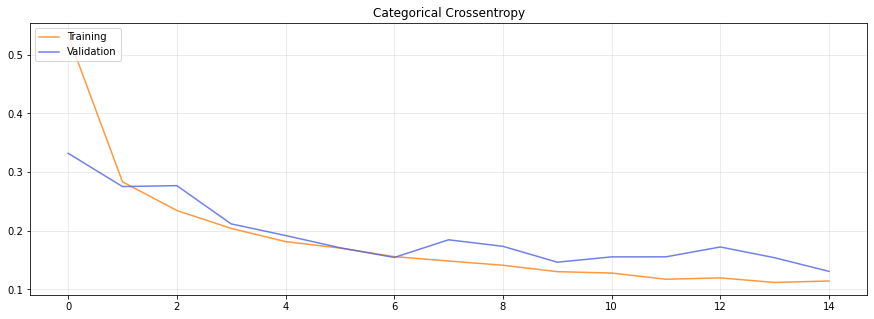

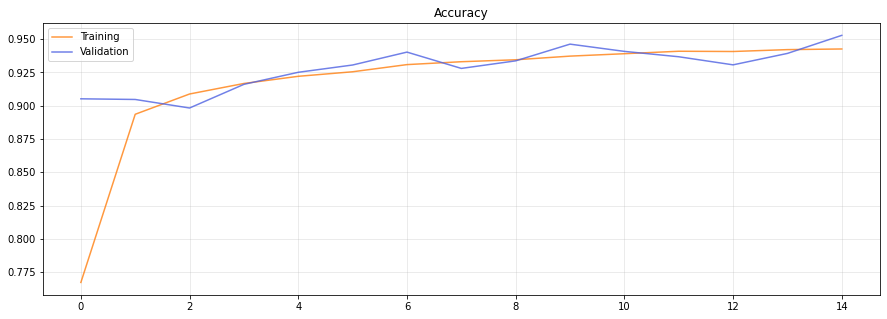

In [ ]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
#Computing the prediction of the model on the validation set
predictions = []
for element in validation_data_dwt.batch(128).as_numpy_iterator():
    predictions.append(vgg.predict(element[0]))

In [ ]:
predictions_f = [item for sublist in predictions for item in sublist]

In [ ]:
predictions_oh = []
#transform prediction into one-hot-encoding 
for i in range(len(predictions_f)):
    predictions_oh.append(tf.one_hot(tf.argmax(predictions_f[i]), depth=3))

In [ ]:
#Compute the true and prediction array in order to plot the confusion matrix
y = []

for y_t in y_val.tolist():
    if(y_t == [1, 0, 0]):
        y.append('N')
    if(y_t == [0, 1 ,0]):
        y.append('S')
    if(y_t == [0, 0 ,1]):
        y.append('V')    

y_pred = []

for y_t in predictions_oh:
    if(all(tf.equal(y_t, tf.constant([1, 0, 0], dtype=np.float32)))):
        y_pred.append('N')
    elif(all(tf.equal(y_t, tf.constant([0, 1, 0], dtype=np.float32)))):
        y_pred.append('S')
    elif(all(tf.equal(y_t, tf.constant([0, 0, 1], dtype=np.float32)))):
        y_pred.append('V')  
    else:
        print(y_t)

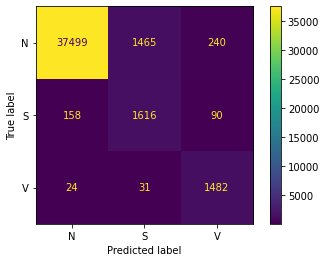

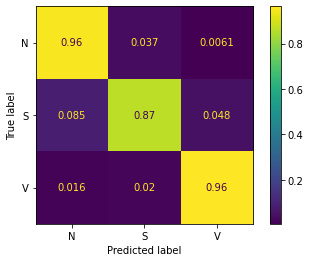

In [ ]:
#Plotting the confusion matrix
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.metrics import confusion_matrix

ConfusionMatrixDisplay.from_predictions(y, y_pred, labels = ['N', 'S', 'V'])
ConfusionMatrixDisplay.from_predictions(y, y_pred, normalize='true', labels = ['N', 'S', 'V'])

In [ ]:
print(classification_report(y,y_pred))

              precision    recall  f1-score   support

           N       1.00      0.96      0.98     39204
           S       0.52      0.87      0.65      1864
           V       0.82      0.96      0.89      1537

    accuracy                           0.95     42605
   macro avg       0.78      0.93      0.84     42605
weighted avg       0.97      0.95      0.96     42605



# ResNet

Try to use an advanced model to deal with vanishing gradient which uses skip connections to allow a deeper architecture

In [ ]:
# ResNet model definition component by component
import tensorflow.keras.layers as tfkl

def ResBs_Conv(block_input, num_filters): 
   
    # Filter Block input and BatchNormalization
    block_input = tfkl.Conv1D(num_filters, kernel_size=7, strides = 2,  padding = 'same')(block_input) 
    block_input = tfkl.BatchNormalization()(block_input)

    # First Convolutional Layer
    conv1 = tfkl.Conv1D(filters=num_filters, kernel_size=7, padding= 'same')(block_input)
    norm1 = tfkl.BatchNormalization()(conv1)
    relu1 = tfkl.Activation('relu')(norm1)  
    dropout = tfkl.Dropout(0.2)(relu1)
    
    # Second Convolutional Layer 
    conv2 = tfkl.Conv1D(num_filters, kernel_size=7, padding= 'same')(dropout)
    norm2 = tfkl.BatchNormalization()(conv2)

    # Summing Layer (adding a residual connection)
    sum = tfkl.Add()([block_input, norm2])
    
    # Activation Layer
    relu2 = tfkl.Activation('relu')(sum)
    
    return relu2 

def ResBs_Identity(block_input, num_filters): 

    # First Convolutional Layer
    conv1 = tfkl.Conv1D(filters=num_filters, kernel_size=7, padding= 'same')(block_input)
    norm1 = tfkl.BatchNormalization()(conv1)
    relu1 = tfkl.Activation('relu')(norm1)    
    dropout = tfkl.Dropout(0.2)(relu1)
    
    # Second Convolutional Layer 
    conv2 = tfkl.Conv1D(num_filters, kernel_size=7, padding= 'same')(dropout)
    norm2 = tfkl.BatchNormalization()(conv2)

    # Summing Layer (adding a residual connection)
    sum = tfkl.Add()([block_input, norm2])
    
    # Activation Layer
    relu2 = tfkl.Activation('relu')(sum)
    
    return relu2 

def resnet(N=8, ch=1, win_len=max_len, classes=3): 
    ecg_input = tfkl.Input(shape=(win_len, ch), name='ecg_signal') 

    ResNet = tfkl.Conv1D(filters=64,kernel_size=15, padding = 'same')(ecg_input) 
    ResNet = tfkl.BatchNormalization()(ResNet)
    ResNet = tfkl.Activation('relu')(ResNet)
    ResNet = tfkl.MaxPooling1D(pool_size=2, strides = 2)(ResNet)
    
    # First two ResNet blocks are identity blocks 
    ResNet = ResBs_Identity(ResNet, 64)
    ResNet = ResBs_Identity(ResNet, 64)

    filters = 64
    M= int((N -2 )/2)
    for i in range(M): 
        filters = filters*2
        # define N-th ResBs block
        ResNet = ResBs_Conv(ResNet, filters)
        ResNet = ResBs_Identity(ResNet, filters)
    
    ResNet = tfkl.GlobalMaxPooling1D(name='gmp_layer')(ResNet)
    ResNet = tfkl.Flatten()(ResNet) 

    # Sigmoid activation function on the last layer
    ResNet = tfkl.Dense(classes, activation='sigmoid',  name='sigmoid_classifier')(ResNet)

    # Finally the model is composed by connecting inputs to outputs: 
    model = tf.keras.Model(inputs=[ecg_input],outputs=ResNet)
    return model

In [ ]:
resNet = resnet(N=8, ch=1, win_len=max_len, classes=3)

learning_rate = 0.001
resNet.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy', 'Precision', 'Recall' ]
)

In [ ]:
resNet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ecg_signal (InputLayer)        [(None, 223, 1)]     0           []                               
                                                                                                  
 conv1d_20 (Conv1D)             (None, 223, 64)      1024        ['ecg_signal[0][0]']             
                                                                                                  
 batch_normalization_20 (BatchN  (None, 223, 64)     256         ['conv1d_20[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_17 (Activation)     (None, 223, 64)      0           ['batch_normalization_20[0]

In [ ]:
class_weights

{0: 0.3622506350370394, 1: 7.620919416867901, 2: 9.236802168021681}

In [ ]:
batch_size = 128

history_resNet = resNet.fit(
    x=batch_generator_data(batch_size=batch_size, x_gen=generate_X_shuffle(X_train), y_gen=generate_y_shuffle(y_train)),
    validation_data= validation_data.batch(batch_size),
    steps_per_epoch=compute_steps(len(X_train), batch_size),
    epochs = 20,
    class_weight = class_weights
     ).history

Epoch 1/20
1332/1332 [==============================] - 287s 205ms/step - loss: 0.6052 - accuracy: 0.7844 - precision: 0.5800 - recall: 0.9381 - val_loss: 0.4220 - val_accuracy: 0.8115 - val_precision: 0.5414 - val_recall: 0.9496
Epoch 2/20
1332/1332 [==============================] - 271s 204ms/step - loss: 0.2733 - accuracy: 0.8927 - precision: 0.6183 - recall: 0.9725 - val_loss: 0.2483 - val_accuracy: 0.8990 - val_precision: 0.6330 - val_recall: 0.9712
Epoch 3/20
1332/1332 [==============================] - 270s 203ms/step - loss: 0.2260 - accuracy: 0.9126 - precision: 0.6380 - recall: 0.9819 - val_loss: 0.2280 - val_accuracy: 0.9041 - val_precision: 0.6833 - val_recall: 0.9826
Epoch 4/20
1332/1332 [==============================] - 278s 208ms/step - loss: 0.2118 - accuracy: 0.9167 - precision: 0.6449 - recall: 0.9832 - val_loss: 0.3031 - val_accuracy: 0.8865 - val_precision: 0.6472 - val_recall: 0.9756
Epoch 5/20
1332/1332 [==============================] - 271s 203ms/step - loss: 

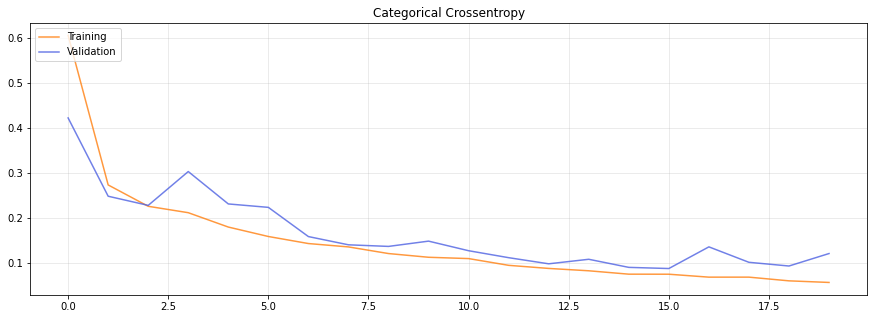

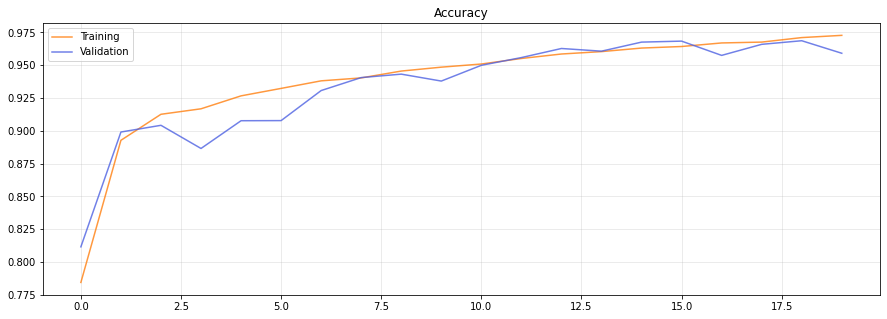

In [ ]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(history_resNet['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history_resNet['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history_resNet['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history_resNet['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
resNet.save('/content/drive/MyDrive/AppliedAIinBiomedicine/final-assignment/resnet model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/AppliedAIinBiomedicine/final-assignment/resnet model/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [ ]:
#Computing the prediction of the model on the validation set
predictions = []
for element in validation_data.batch(128).as_numpy_iterator():
    predictions.append(resNet.predict(element[0]))

In [ ]:
predictions_f = [item for sublist in predictions for item in sublist]

In [ ]:
predictions_oh = []
#transform prediction into one-hot-encoding 
for i in range(len(predictions_f)):
    predictions_oh.append(tf.one_hot(tf.argmax(predictions_f[i]), depth=3))

In [ ]:
#Compute the true and prediction array in order to plot the confusion matrix
y = []

for y_t in y_val.tolist():
    if(y_t == [1, 0, 0]):
        y.append('N')
    if(y_t == [0, 1 ,0]):
        y.append('S')
    if(y_t == [0, 0 ,1]):
        y.append('V')    

y_pred = []

for y_t in predictions_oh:
    if(all(tf.equal(y_t, tf.constant([1, 0, 0], dtype=np.float32)))):
        y_pred.append('N')
    elif(all(tf.equal(y_t, tf.constant([0, 1, 0], dtype=np.float32)))):
        y_pred.append('S')
    elif(all(tf.equal(y_t, tf.constant([0, 0, 1], dtype=np.float32)))):
        y_pred.append('V')  
    else:
        print(y_t)

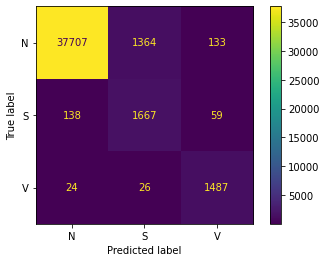

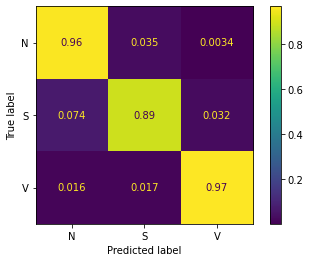

In [ ]:
#Plotting the confusion matrix
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.metrics import confusion_matrix

ConfusionMatrixDisplay.from_predictions(y, y_pred, labels = ['N', 'S', 'V'])
ConfusionMatrixDisplay.from_predictions(y, y_pred, normalize='true', labels = ['N', 'S', 'V'])

In [ ]:
print(classification_report(y,y_pred))

              precision    recall  f1-score   support

           N       1.00      0.96      0.98     39204
           S       0.55      0.89      0.68      1864
           V       0.89      0.97      0.92      1537

    accuracy                           0.96     42605
   macro avg       0.81      0.94      0.86     42605
weighted avg       0.97      0.96      0.96     42605



### Input change experiment

Here we try to give in input to the network not just the beat to be classified but also the previous and the next ones in order to exploit the high correlation between near beats

In [ ]:
# Modify the data generator to create this new kind of input
# This implementation take into account only the target and the previous beat
def batch_generator_data_near_beats(batch_size, x_gen, y_gen): 
    
    #change batch features shape
    batch_features = np.zeros((batch_size, max_len*2, 1))
    batch_labels = np.zeros((batch_size,3)) 

    prev = np.zeros((max_len, 1))
    
    while True:
        for i in range(batch_size):
            single_input = []

            current = next(x_gen)
            single_input.append(prev)
            single_input.append(current)

            prev = current

            batch_features[i] = np.concatenate(single_input, axis=0)
            batch_labels[i] = next(y_gen)
        
        X = [batch_features]


        yield X, batch_labels


In [ ]:
#change input_shape of the model to try

cnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=16, kernel_size=3, padding='same',
                        activation=tf.nn.leaky_relu, input_shape=[max_len*2, 1]),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                        padding='same', activation=tf.nn.leaky_relu),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(128, activation=tf.nn.leaky_relu),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(3, activation=tf.nn.softmax)
])

In [ ]:
learning_rate = 0.001
cnn_model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy', tf.keras.metrics.Precision(),tf.keras.metrics.Recall()]
)

In [ ]:
# Try if the new generator works
batch_size = 16

history = cnn_model.fit(
    x = batch_generator_data_near_beats(batch_size = batch_size, x_gen = generate_X_shuffle(X_train), y_gen = generate_y_shuffle(y_train)), 
    validation_data=validation_data.batch(batch_size),
    steps_per_epoch=compute_steps(len(X_train), batch_size),
    epochs = 15,
    callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True),
    class_weight = class_weights
).history

Epoch 1/15
  741/10652 [=>............................] - ETA: 2:01 - loss: 1.0313 - accuracy: 0.4174 - precision_2: 0.3472 - recall_2: 0.1012

KeyboardInterrupt: ignored